## Hierarchical Clustering

Hierarchical clustering is a method of cluster analysis that builds a hierarchy of clusters. Unlike K-Means, which requires the user to specify the number of clusters upfront, hierarchical clustering allows for a more exploratory approach.

There are two main types:

    Agglomerative (Bottom-Up): Starts with each observation as its own cluster and iteratively merges clusters.
    Divisive (Top-Down): Starts with a single cluster containing all observations and iteratively splits it.

We will use Agglomerative Clustering here, which is the more common approach.
Distance Metrics and Linkage Criteria

Distance Metrics: Measure the proximity between observations. Common metrics include:

    Euclidean Distance: Straight-line distance in a multidimensional space.
    Manhattan Distance: Sum of absolute differences across dimensions.

Linkage Criteria: Determine the distance between clusters:

    Single Linkage: The shortest distance between points in different clusters.
    Complete Linkage: The longest distance between points in different clusters.
    Average Linkage: The average distance between points in different clusters.

These criteria influence the shape of clusters.

In [1]:
# import required libraries for dataframe and visualization

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# import required libraries for clustering
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [2]:
# Reading the data on which analysis needs to be done

retail = pd.read_csv('OnlineRetail.csv', sep=",", encoding="ISO-8859-1", header=0)
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


### Data Cleansing

In [3]:
# Calculating the Missing Values % contribution in DF

df_null = round(100*(retail.isnull().sum())/len(retail), 2)
df_null

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

In [4]:
retail = retail.dropna()
retail.shape

(406829, 8)

In [5]:
# Changing the datatype of Customer Id as per Business understanding
retail['CustomerID'] = retail['CustomerID'].astype(str)

### Data Preparation

In [6]:
# New Attribute : Monetary
retail['Amount'] = retail['Quantity']*retail['UnitPrice']
rfm_m = retail.groupby('CustomerID')['Amount'].sum()
rfm_m = rfm_m.reset_index()
# New Attribute : Frequency

rfm_f = retail.groupby('CustomerID')['InvoiceNo'].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['CustomerID', 'Frequency']
# Merging the two dfs
rfm = pd.merge(rfm_m, rfm_f, on='CustomerID', how='inner')


In [7]:
# New Attribute : Recency

# Convert to datetime to proper datatype

retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'],format='%d-%m-%Y %H:%M')

In [8]:
# Compute the maximum date to know the last transaction date

max_date = max(retail['InvoiceDate'])
# max_date

In [9]:
# Compute the difference between max date and transaction date

retail['Diff'] = max_date - retail['InvoiceDate']
# retail.head()

In [10]:
# Compute last transaction date to get the recency of customers

rfm_p = retail.groupby('CustomerID')['Diff'].min()
rfm_p = rfm_p.reset_index()
# rfm_p.head()

In [11]:
# Extract number of days only

rfm_p['Diff'] = rfm_p['Diff'].dt.days
# rfm_p.head()

In [12]:
# Merge tha dataframes to get the final RFM dataframe

rfm = pd.merge(rfm, rfm_p, on='CustomerID', how='inner')
rfm.columns = ['CustomerID', 'Amount', 'Frequency', 'Recency']
# rfm.head()

In [13]:
# Rescaling the attributes

rfm_df = rfm[['Amount', 'Frequency', 'Recency']]

# Instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(4372, 3)

In [14]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Amount', 'Frequency', 'Recency']
# rfm_df_scaled.head()

Building the Model

### K-Means Clustering

K-means clustering is one of the simplest and popular unsupervised machine learning algorithms.<br>

The algorithm works as follows:

- First we initialize k points, called means, randomly.
- We categorize each item to its closest mean and we update the mean’s coordinates, which are the averages of the items categorized in that mean so far.
- We repeat the process for a given number of iterations and at the end, we have our clusters.

In [15]:
# k-means with some arbitrary k

kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=4)

In [16]:
kmeans.labels_

array([0, 1, 1, ..., 1, 1, 1], dtype=int32)

In [17]:
 kmeans.labels_

array([0, 1, 1, ..., 1, 1, 1], dtype=int32)

In [18]:
# assign the label
rfm['Cluster_Id'] = kmeans.labels_
# rfm.head()

### Hierarchical Clustering

Hierarchical clustering involves creating clusters that have a predetermined ordering from top to bottom. For example, all files and folders on the hard disk are organized in a hierarchy. There are two types of hierarchical clustering, 
- Divisive 
- Agglomerative.

**Single Linkage:<br>**

In single linkage hierarchical clustering, the distance between two clusters is defined as the shortest distance between two points in each cluster. For example, the distance between clusters “r” and “s” to the left is equal to the length of the arrow between their two closest points.
![](https://www.saedsayad.com/images/Clustering_single.png)

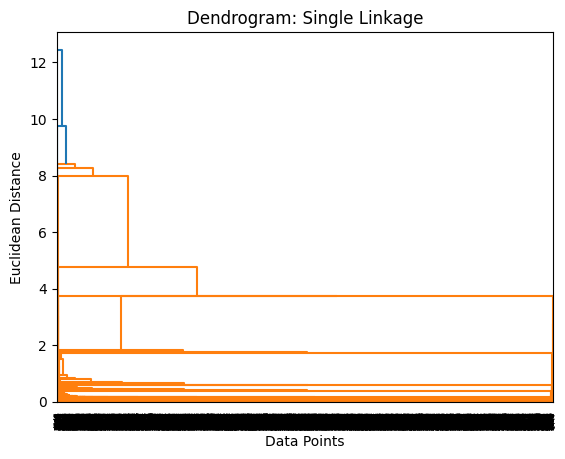

In [19]:
# # Single linkage: 

# mergings = linkage(rfm_df_scaled, method="single", metric='euclidean')
# dendrogram(mergings)
# plt.show()
# Single linkage
mergings = linkage(rfm_df_scaled, method="single", metric='euclidean')
dendrogram(mergings)
plt.title("Dendrogram: Single Linkage")
plt.xlabel("Data Points")
plt.ylabel("Euclidean Distance")
plt.show()


**Complete Linkage<br>**

In complete linkage hierarchical clustering, the distance between two clusters is defined as the longest distance between two points in each cluster. For example, the distance between clusters “r” and “s” to the left is equal to the length of the arrow between their two furthest points. 
![](https://www.saedsayad.com/images/Clustering_complete.png)

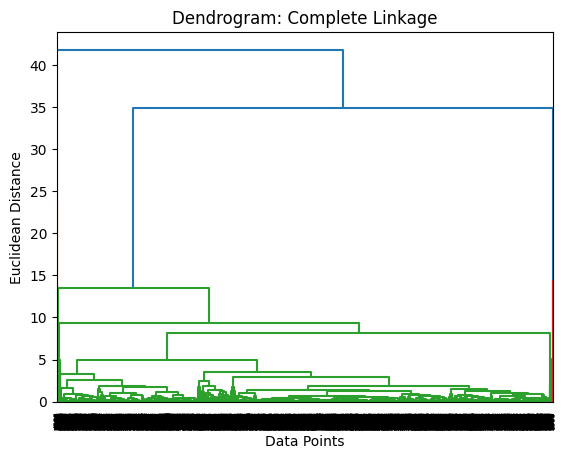

In [20]:
# Complete linkage
mergings = linkage(rfm_df_scaled, method="complete", metric='euclidean')
dendrogram(mergings)
plt.title("Dendrogram: Complete Linkage")
plt.xlabel("Data Points")
plt.ylabel("Euclidean Distance")
plt.show()


**Average Linkage:<br>**

In average linkage hierarchical clustering, the distance between two clusters is defined as the average distance between each point in one cluster to every point in the other cluster. For example, the distance between clusters “r” and “s” to the left is equal to the average length each arrow between connecting the points of one cluster to the other.
![](https://www.saedsayad.com/images/Clustering_average.png)

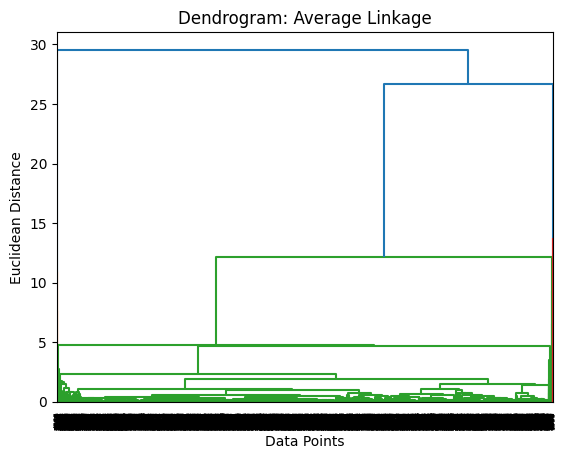

In [21]:
# Average linkage
mergings = linkage(rfm_df_scaled, method="average", metric='euclidean')
dendrogram(mergings)
plt.title("Dendrogram: Average Linkage")
plt.xlabel("Data Points")
plt.ylabel("Euclidean Distance")
plt.show()


#### Cutting the Dendrogram based on K

In [22]:
# Cutting the dendrogram for 3 clusters
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
rfm['Cluster_Labels'] = cluster_labels
rfm.head()


,CustomerID,Amount,Frequency,Recency,Cluster_Id,Cluster_Labels
0,12346.0,0.00,2,325,0,0
1,12347.0,4310.00,182,1,1,0
2,12348.0,1797.24,31,74,1,0
3,12349.0,1757.55,73,18,1,0
4,12350.0,334.40,17,309,0,0


In [23]:
# Assign cluster labels

rfm['Cluster_Labels'] = cluster_labels
rfm.head()

,CustomerID,Amount,Frequency,Recency,Cluster_Id,Cluster_Labels
0,12346.0,0.00,2,325,0,0
1,12347.0,4310.00,182,1,1,0
2,12348.0,1797.24,31,74,1,0
3,12349.0,1757.55,73,18,1,0
4,12350.0,334.40,17,309,0,0


<Axes: xlabel='Cluster_Labels', ylabel='Amount'>

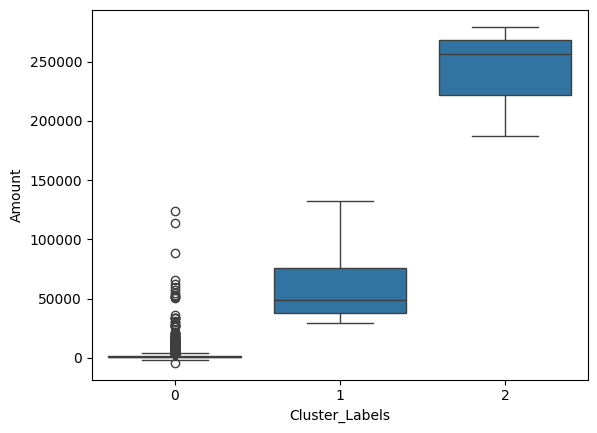

In [24]:
# Plot Cluster Id vs Amount

sns.boxplot(x='Cluster_Labels', y='Amount', data=rfm)

<Axes: xlabel='Cluster_Labels', ylabel='Frequency'>

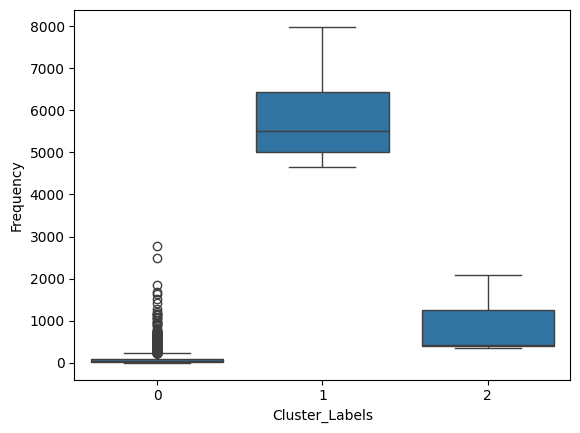

In [25]:
# Plot Cluster Id vs Frequency

sns.boxplot(x='Cluster_Labels', y='Frequency', data=rfm)

<Axes: xlabel='Cluster_Labels', ylabel='Recency'>

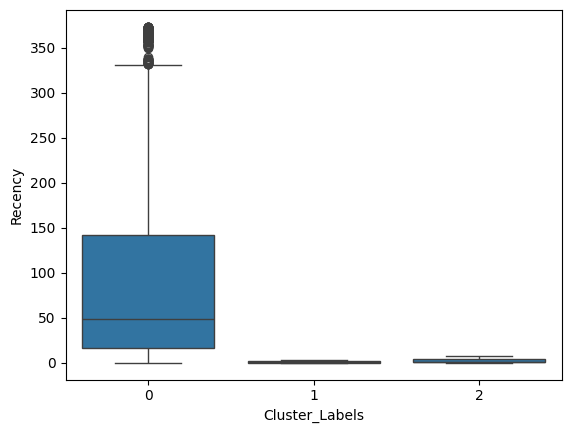

In [26]:
# Plot Cluster Id vs Recency

sns.boxplot(x='Cluster_Labels', y='Recency', data=rfm)

### Advanced Methods for Hierarchical Clustering

    Optimal Number of Clusters:
    Use a more systematic approach to determine the optimal number of clusters:
        Cophenetic Correlation Coefficient: Measure how faithfully a dendrogram preserves pairwise distances.
        Gap Statistic: Compare the total within intra-cluster variance for different numbers of clusters.

    Pre-clustering for Large Datasets:
    Hierarchical clustering can be computationally expensive. Consider reducing dimensionality using PCA before clustering: